## Importar openslide

In [1]:
import os

OPENSLIDE_PATH = r'C:\Users\achav\Documents\Osteoartritis\openslide-win64\bin'

if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
        print('Using OpenSlide from', openslide.__file__)
else:
    import openslide

Using OpenSlide from c:\Users\achav\Documents\Osteoartritis\venv\Lib\site-packages\openslide\__init__.py


## Seleccionar la imagen que se va a segmentar

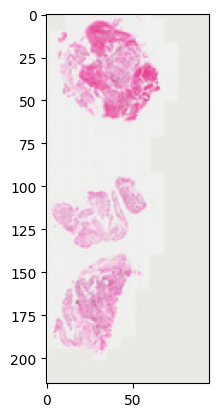

In [2]:
import openslide
import numpy as np
import matplotlib.pyplot as plt

plate_name = "MS-31-23_001"
filename = plate_name + ".svs"
dir_path = f"assets/{plate_name}"
file_path = f"{dir_path}/{filename}"

# Check if file exists
if not os.path.isfile(file_path):
    print(f"File {file_path} not found")

slide = openslide.OpenSlide(file_path)

# Get a thumbnail of the whole slide
thumbnail = slide.get_thumbnail((slide.dimensions[0] // 256, slide.dimensions[1] // 256))

# Convert the thumbnail to a numpy array
thumbnail = np.array(thumbnail)

# Display the thumbnail
plt.imshow(thumbnail)


### Leer las anotaciones que se hicieron sobre la imagen


In [3]:
import xml.etree.ElementTree as ET

path_xml = f"{dir_path}/{plate_name}.xml"

tree = ET.parse(path_xml)
root = tree.getroot()

# Obtener las coordenadas de las anotaciones
coordinates = []
for annotation in root.findall(".//Annotation"):
    for region in annotation.findall(".//Region"):
        coordinates_region = []
        for vertex in region.findall(".//Vertex"):
            x = int(vertex.attrib['X'])
            y = int(vertex.attrib['Y'])
            coordinates_region.append((x, y))
        coordinates.append(coordinates_region)
        
print(len(coordinates))
for coordinates_region in coordinates:
    print(coordinates_region)

## Delete first four elements
# del coordenadas_anotaciones[0:4]

print(len(coordinates))
for coordinates_region in coordinates:
    print(coordinates_region)

2
[(3403, 41326), (3398, 41331), (3395, 41331), (3395, 41333), (3393, 41336), (3390, 41338), (3388, 41341), (3385, 41344), (3382, 41346), (3380, 41349), (3377, 41351), (3377, 41354), (3375, 41354), (3372, 41354), (3370, 41356), (3367, 41359), (3364, 41362), (3362, 41362), (3362, 41364), (3359, 41364), (3359, 41367), (3357, 41369), (3357, 41372), (3354, 41372), (3354, 41374), (3354, 41377), (3352, 41377), (3349, 41377), (3349, 41379), (3347, 41379), (3347, 41382), (3344, 41382), (3344, 41385), (3341, 41387), (3339, 41390), (3336, 41390), (3334, 41390), (3334, 41392), (3331, 41392), (3329, 41395), (3326, 41397), (3323, 41397), (3323, 41400), (3321, 41400), (3318, 41403), (3316, 41403), (3316, 41405), (3313, 41405), (3311, 41408), (3308, 41408), (3308, 41410), (3305, 41410), (3303, 41413), (3300, 41415), (3298, 41415), (3298, 41418), (3295, 41418), (3293, 41418), (3293, 41421), (3290, 41421), (3288, 41423), (3288, 41426), (3285, 41426), (3285, 41428), (3282, 41431), (3282, 41433), (3280, 

## Convertir las anotaciones a la escala adecuada para mostrarlas

In [4]:
# Transform slide to numpy array
import cv2

level = 2
image = slide.read_region((0, 0), level, slide.level_dimensions[level])
image = np.array(image)
image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

print("Image size: ", image.size)

# levels info
print("Level count: ", slide.level_count)
print("Level dimensions: ", slide.level_dimensions)
print(f"Level dimensiones[{level}]: ", slide.level_dimensions[level])
print("Level downsamples: ", slide.level_downsamples)

downsample_factor = 16

# Transform annotations to level 2 (downsampled by 16)
coordenadas_anotaciones_nivel_2 = []
for coordenadas_region in coordinates:
    coordenadas_region_nivel_2 = []
    for x, y in coordenadas_region:
        x_nivel_2 = x // downsample_factor
        y_nivel_2 = y // downsample_factor
        coordenadas_region_nivel_2.append((x_nivel_2, y_nivel_2))
    coordenadas_anotaciones_nivel_2.append(coordenadas_region_nivel_2)

print(coordinates)


Image size:  15892728
Level count:  4
Level dimensions:  ((24448, 55480), (6112, 13870), (1528, 3467), (764, 1733))
Level dimensiones[2]:  (1528, 3467)
Level downsamples:  (1.0, 4.0, 16.00115373521777, 32.0069244085401)
[[(3403, 41326), (3398, 41331), (3395, 41331), (3395, 41333), (3393, 41336), (3390, 41338), (3388, 41341), (3385, 41344), (3382, 41346), (3380, 41349), (3377, 41351), (3377, 41354), (3375, 41354), (3372, 41354), (3370, 41356), (3367, 41359), (3364, 41362), (3362, 41362), (3362, 41364), (3359, 41364), (3359, 41367), (3357, 41369), (3357, 41372), (3354, 41372), (3354, 41374), (3354, 41377), (3352, 41377), (3349, 41377), (3349, 41379), (3347, 41379), (3347, 41382), (3344, 41382), (3344, 41385), (3341, 41387), (3339, 41390), (3336, 41390), (3334, 41390), (3334, 41392), (3331, 41392), (3329, 41395), (3326, 41397), (3323, 41397), (3323, 41400), (3321, 41400), (3318, 41403), (3316, 41403), (3316, 41405), (3313, 41405), (3311, 41408), (3308, 41408), (3308, 41410), (3305, 41410)

## Dibujar las anotaciones escaladas en la imagen a escala

In [5]:
# Draw the annotations on the slide
for coordenadas_region in coordenadas_anotaciones_nivel_2:
    print(coordenadas_region)
    for i in range(len(coordenadas_region)):
        point = coordenadas_region[i]
        next_point = coordenadas_region[(i + 1) % len(coordenadas_region)]
        # color black
        color = (0, 0, 255)
        cv2.line(image, point, next_point, color, 10)

# Draw a solid rectangle around the annotations and a number to identify them
for i, coordenadas_region in enumerate(coordenadas_anotaciones_nivel_2):
    x_min = min(x for x, y in coordenadas_region)
    x_max = max(x for x, y in coordenadas_region)
    y_min = min(y for x, y in coordenadas_region)
    y_max = max(y for x, y in coordenadas_region)
    # color blue (RGB)
    color = (0, 0, 255)
    thickness = 10
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 15
    thickness = 5

    # Draw the number of the annotation in the center of the rectangle
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2
    cv2.putText(image, str(coordenadas_anotaciones_nivel_2.index(coordenadas_region)), (x_center, y_center), font, fontScale, color, thickness, cv2.LINE_AA)
    


[(212, 2582), (212, 2583), (212, 2583), (212, 2583), (212, 2583), (211, 2583), (211, 2583), (211, 2584), (211, 2584), (211, 2584), (211, 2584), (211, 2584), (210, 2584), (210, 2584), (210, 2584), (210, 2584), (210, 2585), (210, 2585), (210, 2585), (209, 2585), (209, 2585), (209, 2585), (209, 2585), (209, 2585), (209, 2585), (209, 2586), (209, 2586), (209, 2586), (209, 2586), (209, 2586), (209, 2586), (209, 2586), (209, 2586), (208, 2586), (208, 2586), (208, 2586), (208, 2586), (208, 2587), (208, 2587), (208, 2587), (207, 2587), (207, 2587), (207, 2587), (207, 2587), (207, 2587), (207, 2587), (207, 2587), (207, 2587), (206, 2588), (206, 2588), (206, 2588), (206, 2588), (206, 2588), (206, 2588), (206, 2588), (206, 2588), (205, 2588), (205, 2588), (205, 2588), (205, 2588), (205, 2588), (205, 2589), (205, 2589), (205, 2589), (205, 2589), (205, 2589), (205, 2589), (205, 2589), (204, 2589), (204, 2589), (204, 2590), (204, 2590), (204, 2590), (204, 2590), (204, 2590), (204, 2590), (204, 2590)

## Presentar la imagen

(3467, 1528, 3)


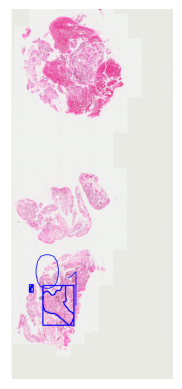

In [6]:
print(image.shape)

# Display the slide with the annotations
plt.imshow(image)

plt.axis('off')  # Hide axis
plt.show()

## Crear el dataset por clase y por imagen

In [7]:
# Create a dataset of images from the slide depending on the annotations
import os
import cv2

# Create a directory to store the images of class A
class_A_dir = os.path.join(dir_path, "class_A")
if not os.path.exists(class_A_dir):
    os.makedirs(class_A_dir)

# Create a directory to store the images of class B
class_B_dir = os.path.join(dir_path, "class_B")
if not os.path.exists(class_B_dir):
    os.makedirs(class_B_dir)

# Create a directory to store the images of class C
class_C_dir = os.path.join(dir_path, "class_C")
if not os.path.exists(class_C_dir):
    os.makedirs(class_C_dir)


## Crear la máscara

In [ ]:
## Convert the annotations to a mask
level = 0
mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]), dtype=np.uint8)

for coordinates_region in coordinates:
    coordinates_region = np.array(coordinates_region)
    cv2.fillPoly(mask, [coordinates_region], 255)

# Save the mask
mask_path = os.path.join(annotations_dir_plate, f"{plate_name}_mask_level_{level}.png")
cv2.imwrite(mask_path, mask)

slide.level_dimensions[level]
mask.shape

# Create a thumbnail of the mask
mask_thumbnail = cv2.resize(mask, (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)

## Show a thumbnail of the mask
plt.imshow(mask_thumbnail, cmap='gray')

## make a sound when the process is finished
import winsound
frequency = 1760  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Seleccionar la anotación para extraer los campos de visión

In [ ]:
# For each annotation, create a dataset of images

# Get the size of the images
size = 1024

# Choose annotation and its class directory
coordenadas_region = coordenadas_anotaciones[1]
dir = class_B_dir_plate

print(dir)

# Find the bounding box of the annotations
x_min = min(x for x, y in coordenadas_region)
x_max = max(x for x, y in coordenadas_region)
y_min = min(y for x, y in coordenadas_region)
y_max = max(y for x, y in coordenadas_region)

# Iterate over the bounding box of the annotations and extract the images
for x in range(x_min, x_max, 3*size//4):
    for y in range(y_min, y_max, 3*size//4):
        print(x, y)
        # Extract the image
        image = np.array(slide.read_region((x, y), 0, (size, size)))
        # Check if more than 80 % of the image is inside the annotations
        mask_region = mask[y:y + size, x:x + size]
        if np.count_nonzero(mask_region) > 0.8 * size * size:
            print("Inside annotation: ", x, y)
            # Save the image to the chosen directory
            image_path = os.path.join(dir, f"{x}_{y}.png")
            cv2.imwrite(image_path, image)

winsound.Beep(frequency, duration)


## Reducir el tamaño de las imágenes

In [ ]:
import pathlib
import cv2

data_dir = pathlib.Path("dataset")

image_count = len(list(data_dir.glob('**/*.png')))

class_a = list(data_dir.glob('class_A/**/*.png'))
class_b = list(data_dir.glob('class_B/**/*.png'))

print(len(class_a))
print(len(class_b))

print(image_count)

# Set the size of the images
size = 128

# List the subdirectories inside the classes directories
class_a_dirs = list(data_dir.glob('class_A/*'))
class_b_dirs = list(data_dir.glob('class_B/*'))

print(class_a_dirs)
print(class_b_dirs)

# Create a subdirectory for the resized images inside each subdirectory of the classes directories

for dir in class_a_dirs:
    resized_dir = dir / f"resized_{size}"
    if not resized_dir.exists():
        resized_dir.mkdir()

    # Resize the images inside the subdirectory
    for image_path in dir.glob('*.png'):
        image = cv2.imread(str(image_path))
        image_resized = cv2.resize(image, (size, size))
        cv2.imwrite(str(resized_dir / image_path.name), image_resized)

for dir in class_b_dirs:
    resized_dir = dir / f"resized_{size}"
    if not resized_dir.exists():
        resized_dir.mkdir()

    for image_path in dir.glob('*.png'):
        image = cv2.imread(str(image_path))
        image_resized = cv2.resize(image, (size, size))
        cv2.imwrite(str(resized_dir / image_path.name), image_resized)
                                                 
